In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import balanced_accuracy_score, accuracy_score,confusion_matrix
from transformers import BertTokenizer
from data.dataloader import build_train_test_dataset
import tqdm
import numpy as np

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "../../scripts/checkpoints/MMSERALayerNorm/20230607-101548/weights/best_acc/checkpoint_0.pt"
model = torch.load(model_path, map_location=device)
test_file = open("../../scripts/data/test_data.pkl", "rb")
test_list = pickle.load(test_file)
# Multi-modal prediction

sprectromes = []
texts = []
y_actu=[]
y_pred=[]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model.to(device)
model.eval()
for every_test_list in tqdm.tqdm(test_list):
    label1=every_test_list['label']

    label1=torch.tensor([label1])
    label1 = label1.to(device)
    sprectrome = every_test_list['sprectrome']
    sprectrome = sprectrome.to(device)
    text=every_test_list['text']
    texts.append(text)
    sprectromes.append(sprectrome)
    input_ids = torch.tensor(tokenizer.encode(text, add_special_tokens=True)).unsqueeze(0)
    input_ids = input_ids.to(device)
    with torch.no_grad():
      if(sprectrome.shape[2]>65):
        output = model(input_ids,sprectrome)
        _, preds = torch.max(output, 1)
        y_actu.append(label1.cpu().numpy()[0])
        y_pred.append(preds.cpu().numpy()[0])
accuracy_score(y_actu, y_pred)

100%|██████████| 933/933 [00:46<00:00, 20.25it/s]


0.7995712754555199

In [12]:
y_n_pred = np.array(y_pred)
y_n_actu = np.array(y_actu)
false = np.where(y_n_pred != y_n_actu)[0]

In [13]:
import csv
with open("false_case.csv", 'w') as f:
  csvwriter = csv.writer(f) 
  csvwriter.writerow(["Actual", "Pred", "Text"])
  
  cls_name = ["Anger", "Happiness", "Sadness", "Neutral"]
  for index in false:
    csvwriter.writerow([cls_name[y_n_actu[index]], cls_name[y_n_pred[index]], texts[index]])

[[153   6   2  16]
 [  9 237   6  29]
 [  5   5 169  25]
 [ 21  43  20 187]]


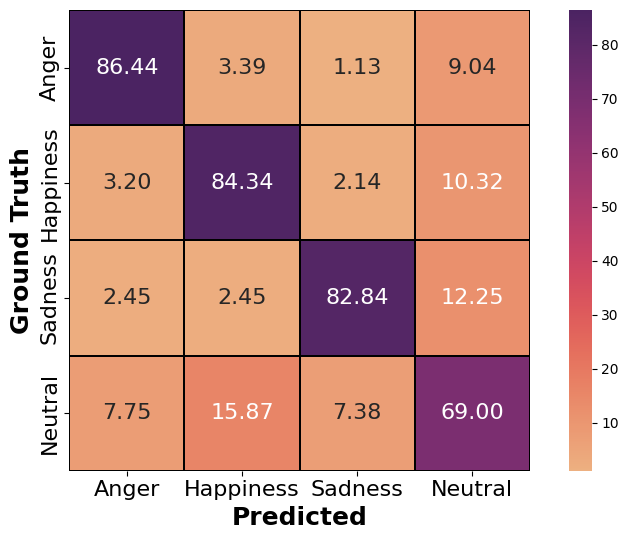

In [14]:
cm = confusion_matrix(y_actu, y_pred)
print(cm)
cmn = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100

ax = plt.subplots(figsize=(8, 5.5))[1]
sns.heatmap(cmn, cmap='flare', annot=True, square=True, linecolor='black', linewidths=0.75, ax = ax, fmt = '.2f', annot_kws={'size': 16})
ax.set_xlabel('Predicted', fontsize=18, fontweight='bold')
ax.xaxis.set_label_position('bottom')
ax.xaxis.set_ticklabels(["Anger", "Happiness", "Sadness", "Neutral"], fontsize=16)
ax.set_ylabel('Ground Truth', fontsize=18, fontweight='bold')
ax.yaxis.set_ticklabels(["Anger", "Happiness", "Sadness", "Neutral"], fontsize=16)
plt.tight_layout()
plt.savefig('WithLayernorm.png', format='png', dpi=1200)
plt.show()

In [15]:
wa = balanced_accuracy_score(y_actu, y_pred)
ua = accuracy_score(y_actu, y_pred)
print("Weighted Accuracy: ", wa)
print("Unweighted Accuracy: ", ua)

Weighted Accuracy:  0.8065728556714504
Unweighted Accuracy:  0.7995712754555199
